## Objective 

MNIST의 글자 종류는 0부터 9까지 10개에 불과합니다. 하지만 한글은 초성,중성,종성의 조합으로 11,172자에 달합니다. 그렇기 때문에 단순히 MNIST와 같이 학습시키기에는 라벨의 수가 지나치게 많아 학습에 어려움이 있습니다. 이러한 문제를 해결하기 위해 초성/중성/종성을 따로 분류하고 조합하는 방식으로 모형을 재설계하였습니다.


In [1]:
%matplotlib inline
import os
import sys

import pandas as pd
import numpy as np

BASE_PATH = os.path.dirname(os.getcwd())
sys.path.append(BASE_PATH)

import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

## 한글 데이터셋 구성하기

직접 synthetic Dataset을 생성하여 학습하였습니다. 나눔 폰트를 이용하여, 랜덤하게 단어 이미지를 만들어서, 학습데이터셋으로 활용하였습니다.

### 한글 matplotlib 출력 세팅

Jupyter Notebook과 Matplotlib은 기본적으로 한글을 지원하지 않습니다. 한글이 출력되려면 아래와 같이 세팅을 해주어야 합니다.

````shell
# 터미널 환경에서 우선 나눔 폰트를 설치해주셔야 합니다.
# 1. 나눔 폰트를 다운받기
apt-get update -qq
apt-get install fonts-nanum* -qq
````

In [2]:
import matplotlib.font_manager as fm
# 2. 나눔 폰트의 위치 가져오기 
system_font = fm.findSystemFonts() # 현재 시스템에 설치된 폰트
nanum_fonts = [font for font in system_font if "NanumBarunGothic.ttf" in font]
font_path = nanum_fonts[0] # 설정할 폰트의 경로

# 3. 나눔 폰트로 설정하기
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc("font",family=font_name)

# 4. 폰트 재설정하기
fm._rebuild()

# 5. (optional) minus 기호 깨짐 방지
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

### 한글 단어 자료 가져오기

한글 단어 사전 데이터셋을 활용하였습니다. 이중에서 특수문자들은 모두 제외하고, 단어길이도 4에서 8 사이로 한정지었습니다.

In [3]:
# 단어 최소/최대 길이
min_words = 4
max_words = 8
df = pd.read_csv(os.path.join(BASE_PATH, "datasets/wordslist.txt"),
                 names=['word'])
df = df.drop_duplicates()
df = df[df.word.str.match(r'^[가-힣]+$')]
df = df[
    df.word.map(
        lambda x: (len(x) >= min_words) 
        and (len(x) <= max_words))]
words = df.word.values
np.random.shuffle(words)
words

array(['주목거리', '마야코프스키', '내떨리다', ..., '뢰명산붕', '와지끈뚝딱', '군현제도'],
      dtype=object)

### 한글 이미지 만들기

아래는 Custom Dataset Class로 한글 단어 텍스트를 입력받으면, 이를 이미지로 변환시켜주는 역할을 합니다. 컴퓨터 폰트를 이용하였기 때문에, 손글씨 보다는 훨씬 전형적이고 규칙적인 이미지를 보이나, 노이즈를 넣어서 좀 더 손글씨에 가까운 수준으로 만들고자 하였습니다.

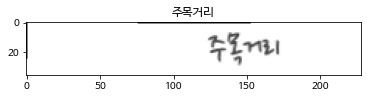

In [4]:
from utils.dataset import OCRDataset

dataset = OCRDataset(words, font_size=24)

image, label = dataset[0]

plt.title(label)
plt.imshow(image[:,:,0],cmap='gray')
plt.show()

반복적으로 생성하면 아래와 같이 다른 폰트, 다른 형태, 다른 위치로 랜덤하게 나옵니다. 이는 기본적인 Data Augmentation을 가해 주어 모델이 노이즈에 강하게 만들어주기 위함입니다.

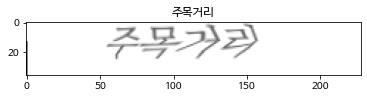

In [5]:
image, label = dataset[0]

plt.title(label)
plt.imshow(image[:,:,0],cmap='gray')
plt.show()

한번에 아래와 같이 복수개의 이미지를 만들 수 있습니다.

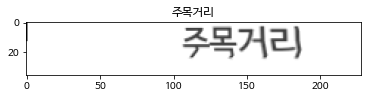

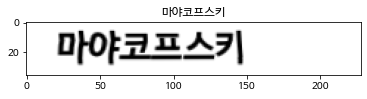

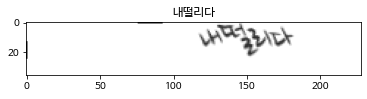

In [6]:
images, labels = dataset[0:3]

for image, label in zip(images, labels):
    plt.title(label)
    plt.imshow(image[:,:,0],cmap='gray')
    plt.show()

데이터셋의 노이즈는 아래와 같이 그 수준을 지정할 수 있습니다.

| argument | Description |
|---|---|
| font_size | 폰트의 Default 크기 |
| bg_noise | 배경 노이즈의 크기  |
| affine_noise |  글자 뒤틀림 노이즈의 크기 |
| color_noise | 글자의 색상 노이즈 크기(gray_scale=False일때만) |


In [7]:
dataset = OCRDataset(words, 
                     font_size=28, 
                     bg_noise=0.3,
                     affine_noise=(0.0, 0.02),
                     color_noise=(0.,0.6),
                     gray_scale=False)

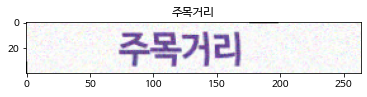

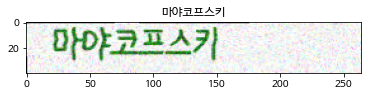

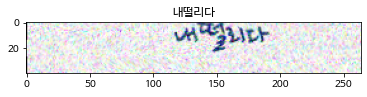

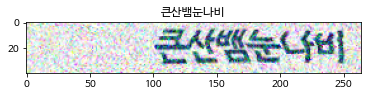

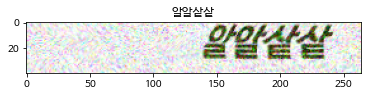

In [8]:
images, labels = dataset[0:5]

for image, label in zip(images, labels):
    plt.title(label)
    plt.imshow(image[:,:],cmap='gray')
    plt.show()

### 4. Data Generator 만들기

아래와 같은 방식으로 데이터 셋 이미지가 만들어 집니다.

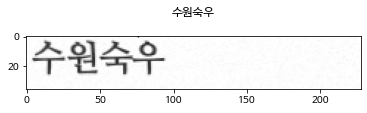

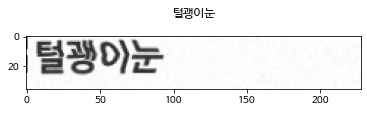

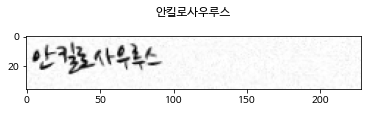

In [11]:
from utils.generator import JAMOSeq2SeqGenerator
from functools import partial
from models.jamo import compose_unicode

# 가능한 한글 폰트들 (나눔 폰트)들을 불러오기
FONT_LIST = [f.name for f in fm.fontManager.ttflist]
FONT_LIST = list(
    set([f for f in FONT_LIST if "Nanum" in f and not 'Square' in f]))

# OCRDataset setting
OCRDataset = partial(OCRDataset,
                     font_size=24,
                     bg_noise=0.2,
                     affine_noise=(0.0,0.01),
                     normalize=False,
                     random_shift=False,                     
                     color_noise=(0.1,0.3),
                     gray_scale=True,
                     font_list=FONT_LIST)

# 단어 군을 기준으로 나누기 
# validation words는 5%만 둚
valid_words = words[:len(words)*5//100]
train_words = words[len(words)*5//100:]
train_words = train_words

valid_set = OCRDataset(valid_words)
train_set = OCRDataset(train_words)

train_gen = JAMOSeq2SeqGenerator(train_set, batch_size=4)
valid_gen = JAMOSeq2SeqGenerator(valid_set, batch_size=4)

X = train_gen[0][0]
for i in range(3):
    image = X['images'][i,:,:,0]
    plt.title(compose_unicode(X['output_sequences'][i])[0])
    plt.imshow(image,cmap='gray')
    plt.show()

## SRN 모델 구성하기


### Image Feature Extractor 구성하기

In [12]:
from models.layers import ResidualConvFeatureExtractor
from tensorflow.keras.layers import Input

In [13]:
K.clear_session()

height = 36

n_conv = 16 # the number of Convolution filter
n_state = 256 # the number of GRU units
n_embed = 16 # the size of embedding vector
n_clf = 256 # the number of units in classifier Dense layer

# Image Encoder
inputs = Input(shape=(height, None, 1),name='images')
conv_maps = ResidualConvFeatureExtractor(n_conv,
                                         name='feature_extractor')(inputs)

### Map2Sequence 구성하기

In [15]:
from models.layers import Map2Sequence

feature_seqs = Map2Sequence(name='map_to_sequence')(conv_maps)

### Embedding Layer 구성하기

임베딩 레이어에서는 텍스트를 임베딩된 숫자로 바꾸어 줍니다. TeacherForcing은 다름이 아니라, 입력값의 timestep을 1씩 뒤로 미루는 작업을 수행합니다.

`JAMAEmbedding`은 내부에서 각 한글을 초성/중성/종성으로 분리시킨 후 임베딩하는 방식입니다.

In [22]:
from models.layers import JamoEmbedding, TeacherForcing

# 교사 강제 학습
y_true = Input(shape=(None,), dtype=tf.int32, name='output_sequences')
decoder_inputs = TeacherForcing()(y_true)

jamo_embedding_layer = JamoEmbedding(n_embed)
jamo_embedding = jamo_embedding_layer(decoder_inputs)

### Text Decoder Layer 구성하기

In [23]:
from tensorflow.keras.layers import GRU

# Text Decoder
gru_layer = GRU(n_state, 
                name='decoder_gru', 
                return_sequences=True)
states_decoder = gru_layer(jamo_embedding)

### Attention Layer 구성하기

In [24]:
from models.layers import DotAttention
from tensorflow.keras.layers import Concatenate

dotattend = DotAttention(n_state=n_state)
context, attention = dotattend([feature_seqs, states_decoder])

concat_state = Concatenate(axis=-1, name='concat_output')(
    [context, states_decoder])

### Character Classification Layer 구성하기

In [25]:
from models.layers import JamoClassifier

# Classifier Layer
jamo_clf = JamoClassifier(n_clf, name='output_seqs')
y_pred = jamo_clf(concat_state)

### Loss Layer 구성하기

In [41]:
from models.losses import JamoCategoricalCrossEntropy

loss = JamoCategoricalCrossEntropy(blank_value=-1.)([y_true, y_pred])

### 학습 모델 구성하기

In [75]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [76]:
# For training
trainer = Model([inputs, y_true],[loss], name='trainer')
trainer.add_loss(loss)

# Model 컴파일하기
trainer.compile(Adam(lr=1e-2))

W0614 09:54:13.782433 4594296256 training_utils.py:1444] Output jamo_categorical_cross_entropy_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to jamo_categorical_cross_entropy_2.


### 모델 학습하기

In [77]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from multiprocessing import cpu_count

callbacks =[]
rlrop = ReduceLROnPlateau(
    factor=0.5, patience=2, 
    min_lr=1e-6, verbose=1,cooldown=5)
callbacks.append(rlrop)

epochs = 50

# 배치 사이즈는 64이상으로 해야 정상적으로 학습이 됩니다.
# 작은 배치는 훨씬 더 불안하게 학습해서 학습시간이 오히려 더 오래 걸립니다.
train_gen = JAMOSeq2SeqGenerator(train_set.config, batch_size=128)
valid_gen = JAMOSeq2SeqGenerator(valid_set.config, batch_size=128)

In [ ]:
hist = trainer.fit_generator(train_gen, steps_per_epoch=1000,                               
                             epochs=epochs, callbacks=callbacks,
                             use_multiprocessing=True, 
                             workers=cpu_count())

## 모델 추론하기

In [ ]:
from models.layers import JamoCompose

# - (1) Encoder
encoder = Model(inputs, feature_seqs, 
                name='encoder')
num_feature = feature_seqs.shape.as_list()[-1]

# - (2) Decoder
states_encoder_input = Input((None, num_feature),
                             name='states_encoder_input')
decoder_state_inputs = Input(shape=(n_state,), name='decoder_state')
decoder_inputs = Input(shape=(None,), name='decoder_inputs')

jamo_embedding = jamo_embedding_layer(decoder_inputs)
states_decoder = gru_layer(jamo_embedding,
                           initial_state=decoder_state_inputs)
context, attention = dotattend([states_encoder_input,
                                states_decoder])
concat_state = Concatenate(axis=-1,name='concat_output')(
    [context, states_decoder])
predictions = jamo_clf(concat_state)
output_decoder = JamoCompose(name='jamocompose')(predictions)

decoder = Model([states_encoder_input,
                 decoder_inputs,
                 decoder_state_inputs], 
                [states_decoder, output_decoder], name='decoder')

#### 평가할 데이터 가져오기

In [ ]:
X, = valid_gen[0]

# Target image 
target_images = X['images'][:10]

#### Encoder에서 이미지를 인코딩하기

In [ ]:
# Encoder 결과 계산
states_encoder_ = encoder.predict(target_images)

#### Decoder에서 텍스트를 디코딩하기

In [ ]:
EOS_TOKEN = ord('\n') # <EOS> 토큰

# Decoder
batch_size = target_images.shape[0]

prev_inputs = np.ones((batch_size,1)) * EOS_TOKEN
prev_states = np.zeros((batch_size, n_state))

In [ ]:
# 재귀적으로 돌아감
result = np.zeros([batch_size,0])
while True:
    states_decoder_, predictions_ = decoder.predict({
        "states_encoder_input" : states_encoder_,
        "decoder_inputs": prev_inputs,
        "decoder_state": prev_states        
    })
    prev_states = states_decoder_[:,-1,:]
    prev_inputs = predictions_
    
    result = np.concatenate([result,prev_inputs],axis=-1)
    if np.all(np.any(result==EOS_TOKEN,axis=1)):
        break    
result = result[:,:].squeeze()
result = result.astype(np.int)

In [ ]:
for image, seq in zip(target_images,result):
    text_seq = "".join([chr(char) for char in seq])
    text_seq = text_seq.split('\n')[0]
    
    plt.title(text_seq)
    plt.imshow(image[:,:,0],cmap='gray')
    plt.show()